# Notebook 02a: K-means Attribute Clusters

Identifying baseline project reference classes with unsupervised clustering.


<a name='index'></a>

# Contents of this notebook


1. 

In [1]:
import os
import sys
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, \
                                  RobustScaler, LabelEncoder

# clustering specific imports
from sklearn.cluster import KMeans
from gap_statistic import OptimalK
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as hac
from scipy.spatial.distance import pdist
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_samples, silhouette_score


# import custom .py functions from src/ directory 
sys.path.append('..')
from src.datagen import print_interval_dict
from src.scale import scale_features, sigmoid, log_plus_one, encode_categories
from src.model import generate_model_dict, print_model_results
from src.visualize import plot_true_pred, plot_bdgt_sched_scaled, \
                          plot_change_trend, plot_line
from src.cluster import silplot, display_gapstat_with_errbars, \
                        fit_neighbors, plot_epsilon, silscore_dbscan, \
                        fit_dbscan, print_dbscan_results

# Avoid scientific notation output in Pandas
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.float_format = '{:,.2f}'.format

# Improve resolution of output graphics
%config InlineBackend.figure_format ='retina'

In [2]:
filepath_train = '../data/processed/NYC_capital_projects_3yr_train.csv'
filepath_test = '../data/processed/NYC_capital_projects_3yr_test.csv'

filepath_data = '../data/interim/NYC_capital_projects_3yr.csv'

savedata_train = '../data/processed/kmeans3_attribute_labels_train.csv'
savedata_test = '../data/processed/kmeans3_attribute_labels_test.csv'
savemodel = '../models/kmeans5_attribute_labels'

if os.path.isfile(filepath_train):
    print("OK - path points to file.")
else:
    print("ERROR - check the 'file_path' and ensure it points to the source file.")

OK - path points to file.


In [3]:
data = pd.read_csv(filepath_data)
data_train = pd.read_csv(filepath_train)
data_test = pd.read_csv(filepath_test)
data_full = pd.read_csv('../data/interim/Capital_Projects_clean.csv') 

In [4]:
# entries
print(f"Number of dataset records: {len(data)}")

# num projects
print(f"Number of unique projects in dataset: {len(data['PID'].unique())}")

Number of dataset records: 149
Number of unique projects in dataset: 149


In [5]:
data_train.shape, data_test.shape

((134, 44), (15, 44))

In [6]:
datetime_cols = [
    'Design_Start',
    'Final_Change_Date',
    'Schedule_Start',
    'Schedule_End',
]

for col in datetime_cols:
    data[col] = pd.to_datetime(data[col])
    data_train[col] = pd.to_datetime(data_train[col])
    data_test[col] = pd.to_datetime(data_test[col])

In [7]:
data.info()

data.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   PID                    149 non-null    int64         
 1   Project_Name           149 non-null    object        
 2   Description            149 non-null    object        
 3   Category               149 non-null    object        
 4   Borough                149 non-null    object        
 5   Managing_Agency        149 non-null    object        
 6   Client_Agency          149 non-null    object        
 7   Phase_Start            149 non-null    object        
 8   Current_Project_Years  149 non-null    float64       
 9   Current_Project_Year   149 non-null    int64         
 10  Design_Start           149 non-null    datetime64[ns]
 11  Budget_Start           149 non-null    float64       
 12  Schedule_Start         149 non-null    datetime64[ns]
 13  Final

,PID,Project_Name,Description,Category,Borough,Managing_Agency,Client_Agency,Phase_Start,Current_Project_Years,Current_Project_Year,...,Schedule_Change,Budget_Change,Schedule_Change_Ratio,Budget_Change_Ratio,Budget_Abs_Per_Error,Budget_Rel_Per_Error,Duration_End_Ratio,Budget_End_Ratio,Duration_Ratio_Inv,Budget_Ratio_Inv
0,3,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,2-Design,5.94,6,...,91,"-15,619,967.29",0.04,-0.08,0.09,0.08,1.04,0.92,-0.04,0.09
1,7,Bowery Bay Waste Water Treatment Plant Main Se...,The existing Main Sewage Pumps have deteriorat...,Wastewater Treatment,Queens,DEP,DEP,2-Design,6.34,7,...,334,"9,618,785.30",0.19,0.18,0.15,0.18,1.19,1.18,-0.16,-0.15
2,91,Mill Basin Bridge Replacement,Complete replacement of bascule bridge with a ...,Bridges,Brooklyn,DOT,not_specified,2-Design,7.44,8,...,247,"-34,672,662.00",0.09,-0.09,0.10,0.09,1.09,0.91,-0.08,0.10


# One hot encode remaining categorical varables

In [8]:
list_cols = list(data.columns)
list_cols[3:12]

['Category',
 'Borough',
 'Managing_Agency',
 'Client_Agency',
 'Phase_Start',
 'Current_Project_Years',
 'Current_Project_Year',
 'Design_Start',
 'Budget_Start']

In [9]:
X_cols = [
    'PID',
    'Category',
    'Borough',
    'Managing_Agency',
    'Client_Agency',
    'Phase_Start',
    'Budget_Start',
    'Duration_Start'
]

In [10]:
X = data[X_cols].set_index('PID')
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149 entries, 3 to 1004
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Category         149 non-null    object 
 1   Borough          149 non-null    object 
 2   Managing_Agency  149 non-null    object 
 3   Client_Agency    149 non-null    object 
 4   Phase_Start      149 non-null    object 
 5   Budget_Start     149 non-null    float64
 6   Duration_Start   149 non-null    int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 9.3+ KB


In [11]:
print('{}\n\n'.format(data['Category'].value_counts()))
print('{}\n\n'.format(data['Managing_Agency'].value_counts()))
print('{}\n\n'.format(data['Client_Agency'].value_counts()))
print('{}\n\n'.format(data['Borough'].value_counts()))
print('{}\n\n'.format(data['Phase_Start'].value_counts()))

Streets and Roadways                  31
Sewers                                20
Schools                               15
Industrial Development                15
Wastewater Treatment                  13
Water Supply                          13
Bridges, Streets and Roadways          9
Bridges                                7
Sanitation                             6
Other Government Facilities            4
Public Safety and Criminal Justice     4
Health and Hospitals                   3
Ferries                                3
Arts and Culture                       2
Parks                                  2
Parks, Streets and Roadways            1
Industrial Development, Parks          1
Name: Category, dtype: int64


DDC     63
DOT     34
DEP     19
SCA     15
EDC     14
DCAS     2
DSNY     2
Name: Managing_Agency, dtype: int64


DEP                    53
not_specified          35
DOT                    17
DOE                    15
DSNY                    7
DCAS                    4
H

In [12]:
# One hot encode categorical variables
drop_cat = 'Other Government Facilities'
one_hot = True

X = encode_categories(
    X, colname='Category',
    one_hot=one_hot,
    drop_cat=drop_cat,
    drop_original_col=True,
    append_colname='cat'
)

drop_cat = 'DSNY'
one_hot = True

X = encode_categories(
    X, colname='Managing_Agency',
    one_hot=one_hot,
    drop_cat=drop_cat,
    drop_original_col=True,
    append_colname='manag'
)

drop_cat = 'not_specified'
one_hot = True

X = encode_categories(
    X, colname='Client_Agency',
    one_hot=one_hot,
    drop_cat=drop_cat,
    drop_original_col=True,
    append_colname='cliag'
)

drop_cat = 'not_specified'
one_hot = True

X = encode_categories(
    X, colname='Borough',
    one_hot=one_hot,
    drop_cat=drop_cat,
    drop_original_col=True,
    append_colname='bor'
)

drop_cat = '4-Construction'
one_hot = True

X = encode_categories(
    X, colname='Phase_Start',
    one_hot=one_hot,
    drop_cat=drop_cat,
    drop_original_col=True
)

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149 entries, 3 to 1004
Data columns (total 58 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Budget_Start                            149 non-null    float64
 1   Duration_Start                          149 non-null    int64  
 2   cat_Arts_and_Culture                    149 non-null    uint8  
 3   cat_Bridges                             149 non-null    uint8  
 4   cat_Bridges,_Streets_and_Roadways       149 non-null    uint8  
 5   cat_Ferries                             149 non-null    uint8  
 6   cat_Health_and_Hospitals                149 non-null    uint8  
 7   cat_Industrial_Development              149 non-null    uint8  
 8   cat_Industrial_Development,_Parks       149 non-null    uint8  
 9   cat_Parks                               149 non-null    uint8  
 10  cat_Parks,_Streets_and_Roadways         149 non-null    uint8

<a name='subset'></a>

# Subset and scale data for X and y frames

<a href=#index>Index</a>

In [13]:
X_train_pids = data_train['PID'].values
X_test_pids = data_test['PID'].values

X_train, X_test = X.loc[X_train_pids], X.loc[X_test_pids]

In [14]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 204 to 113
Data columns (total 58 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Budget_Start                            134 non-null    float64
 1   Duration_Start                          134 non-null    int64  
 2   cat_Arts_and_Culture                    134 non-null    uint8  
 3   cat_Bridges                             134 non-null    uint8  
 4   cat_Bridges,_Streets_and_Roadways       134 non-null    uint8  
 5   cat_Ferries                             134 non-null    uint8  
 6   cat_Health_and_Hospitals                134 non-null    uint8  
 7   cat_Industrial_Development              134 non-null    uint8  
 8   cat_Industrial_Development,_Parks       134 non-null    uint8  
 9   cat_Parks                               134 non-null    uint8  
 10  cat_Parks,_Streets_and_Roadways         134 non-null    uint

In [15]:
#######################################
# CREATE SCALED DATAFRAMES
#######################################

# Identify binary variable columns to exclude from scaling
exclude_scale_cols = list(X)[2:]

# # Reset y dataframe indices or else we will run into indexing issues
# y_train = y_train.reset_index(drop=True)
# y_test = y_test.reset_index(drop=True)


# Standardize both X_train and X_test data, fitting X_train as the
# scaler for both
scaler = StandardScaler
scale_before_func = None
scale_after_func = None
reapply_scaler = False


X_train_std, Scaler_std = scale_features(
    X_train, X_train,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)

X_test_std, _ = scale_features(
    X_train, X_test,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)


# Standardize X_train and X_test, pass through sigmoid transformation
# and re-standardize to minimize skew of data
scaler = StandardScaler
scale_before_func = None
scale_after_func = sigmoid
reapply_scaler = True


X_train_std_sig, Scaler_std_sig = scale_features(
    X_train, X_train,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)

X_test_std_sig, _ = scale_features(
    X_train, X_test,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)

/home/sedelmeyer/Code/cs109b_groupproject/env/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/sedelmeyer/Code/cs109b_groupproject/env/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


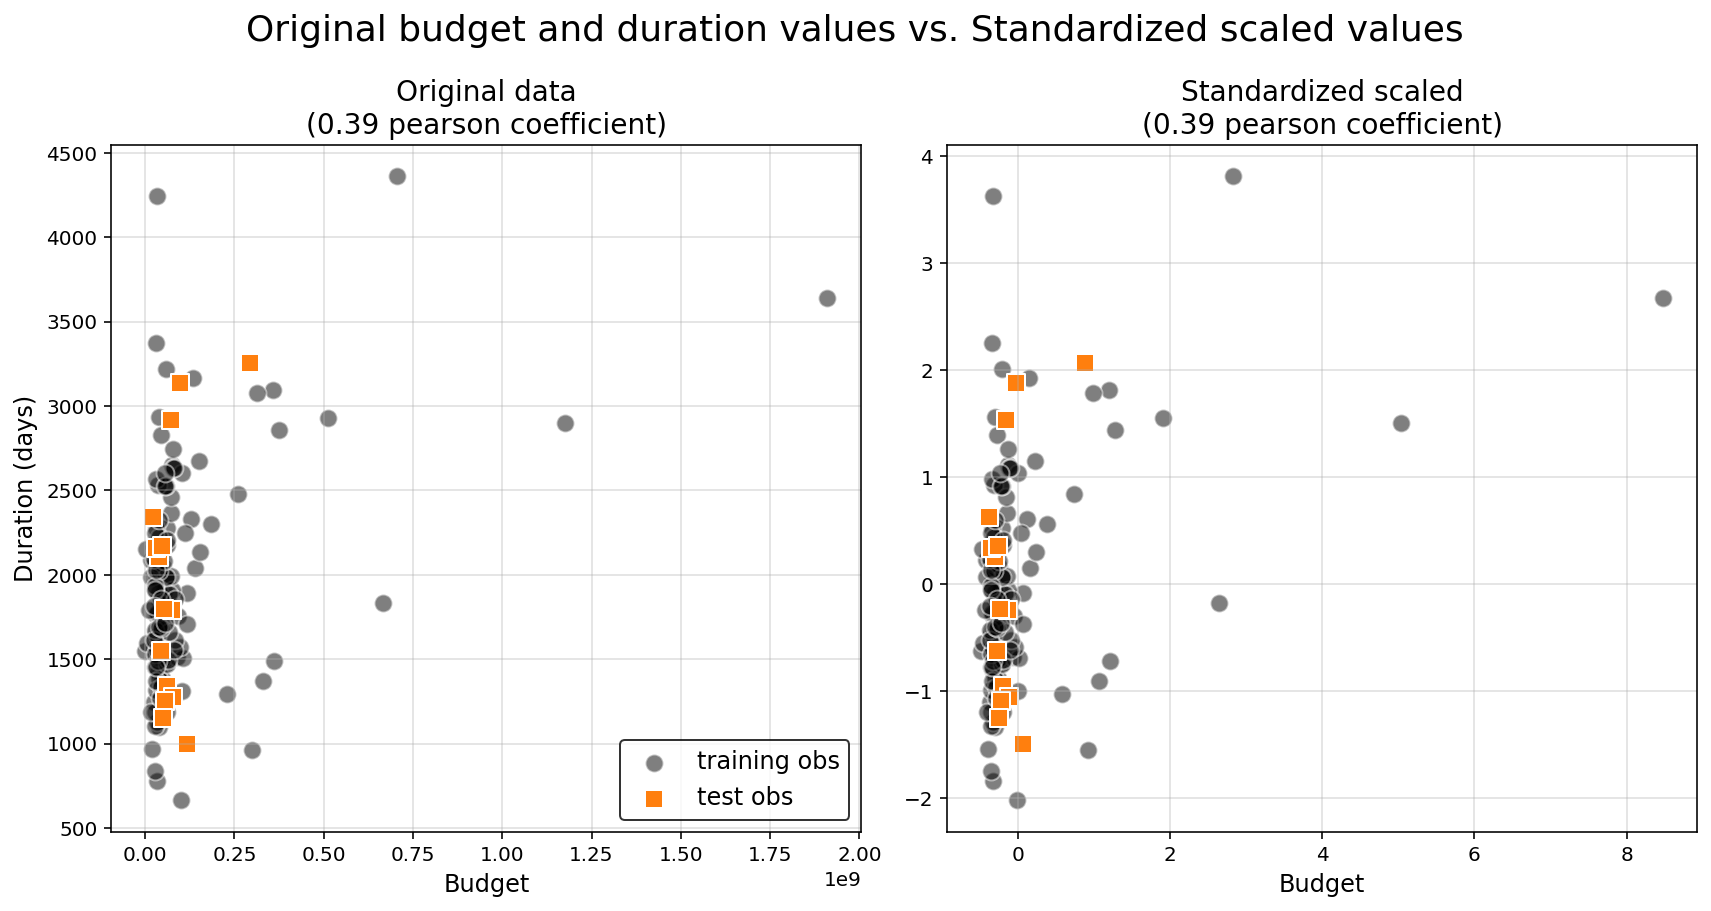

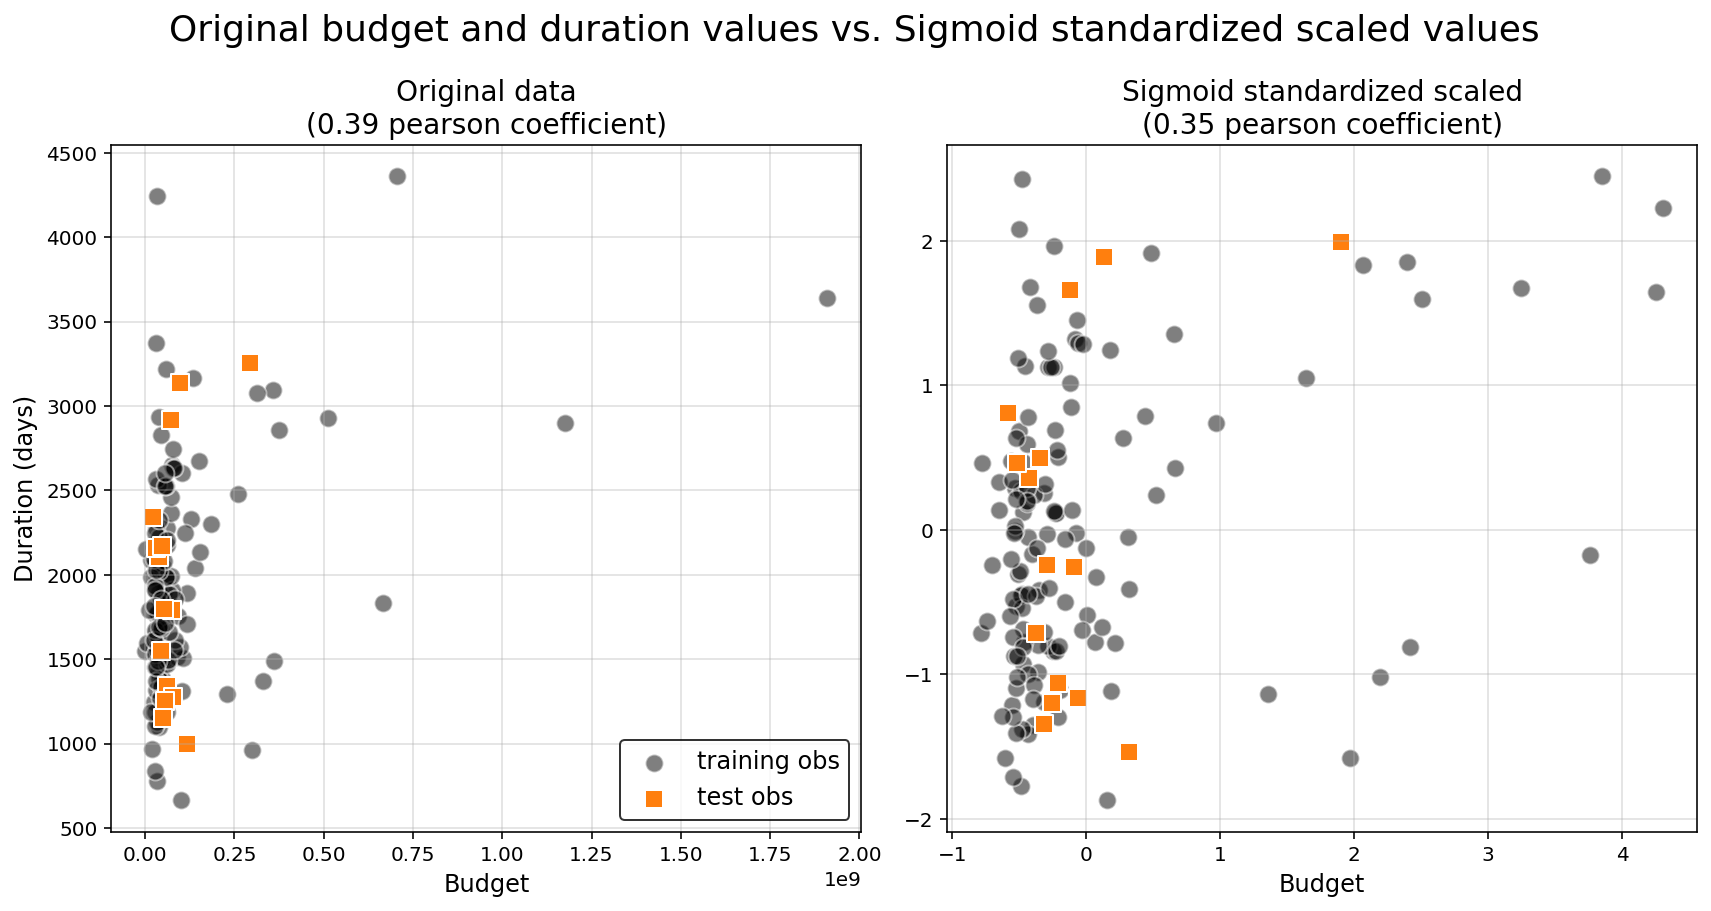

In [16]:
# inspect scaled datasets
plot_bdgt_sched_scaled(X_train, X_train_std, 'Standardized', X_test, X_test_std)
plot_bdgt_sched_scaled(X_train, X_train_std_sig, 'Sigmoid standardized', X_test, X_test_std_sig)

<a name='fit'></a>

# Fit boosted tree models using sklearn AdaBoostRegressor and `generate_model_dict()` function


<a href=#index>Index</a>

#### NOTE:

- I fit two versions of the model below.


- It appears that sometimes, depending on the random state that is set, the standardized sigmoid scaled data sometimes produces a better result for the `Budget_Change_Ratio` predictions  (but not always), while the unscaled data typically produces the best `Schedule_Change_Ratio` results.


- For illustrative purposes, I produce two versions of the model, one with each set of training data. However, in practice, I think we'll want to just use the unscaled data for our boosted tree model.

# Inspect k-means clustering

### Start by running through a range of k-clusters to identify optimal clustering performance

In [17]:
%%time

n_init = 40
random_state = 109

# define version of X scaled data to use throughout the remaining cells
X_data = X_train_std_sig

# define list of k values to compare
k_list = list(np.arange(1,25))

# fit kmeans at each value k and save to dict for future use
# reuse the same n_init=46 and random_state=109 values used previously
kmeans_dict = {
    k: KMeans(n_clusters=k, n_init=n_init, random_state=random_state).fit(X_data)
    for k in k_list
}

# save total within-cluster variation for each kmeans fit
tot_var_vals = [kfit.inertia_ for kfit in kmeans_dict.values()]

CPU times: user 25.4 s, sys: 619 ms, total: 26.1 s
Wall time: 5.4 s


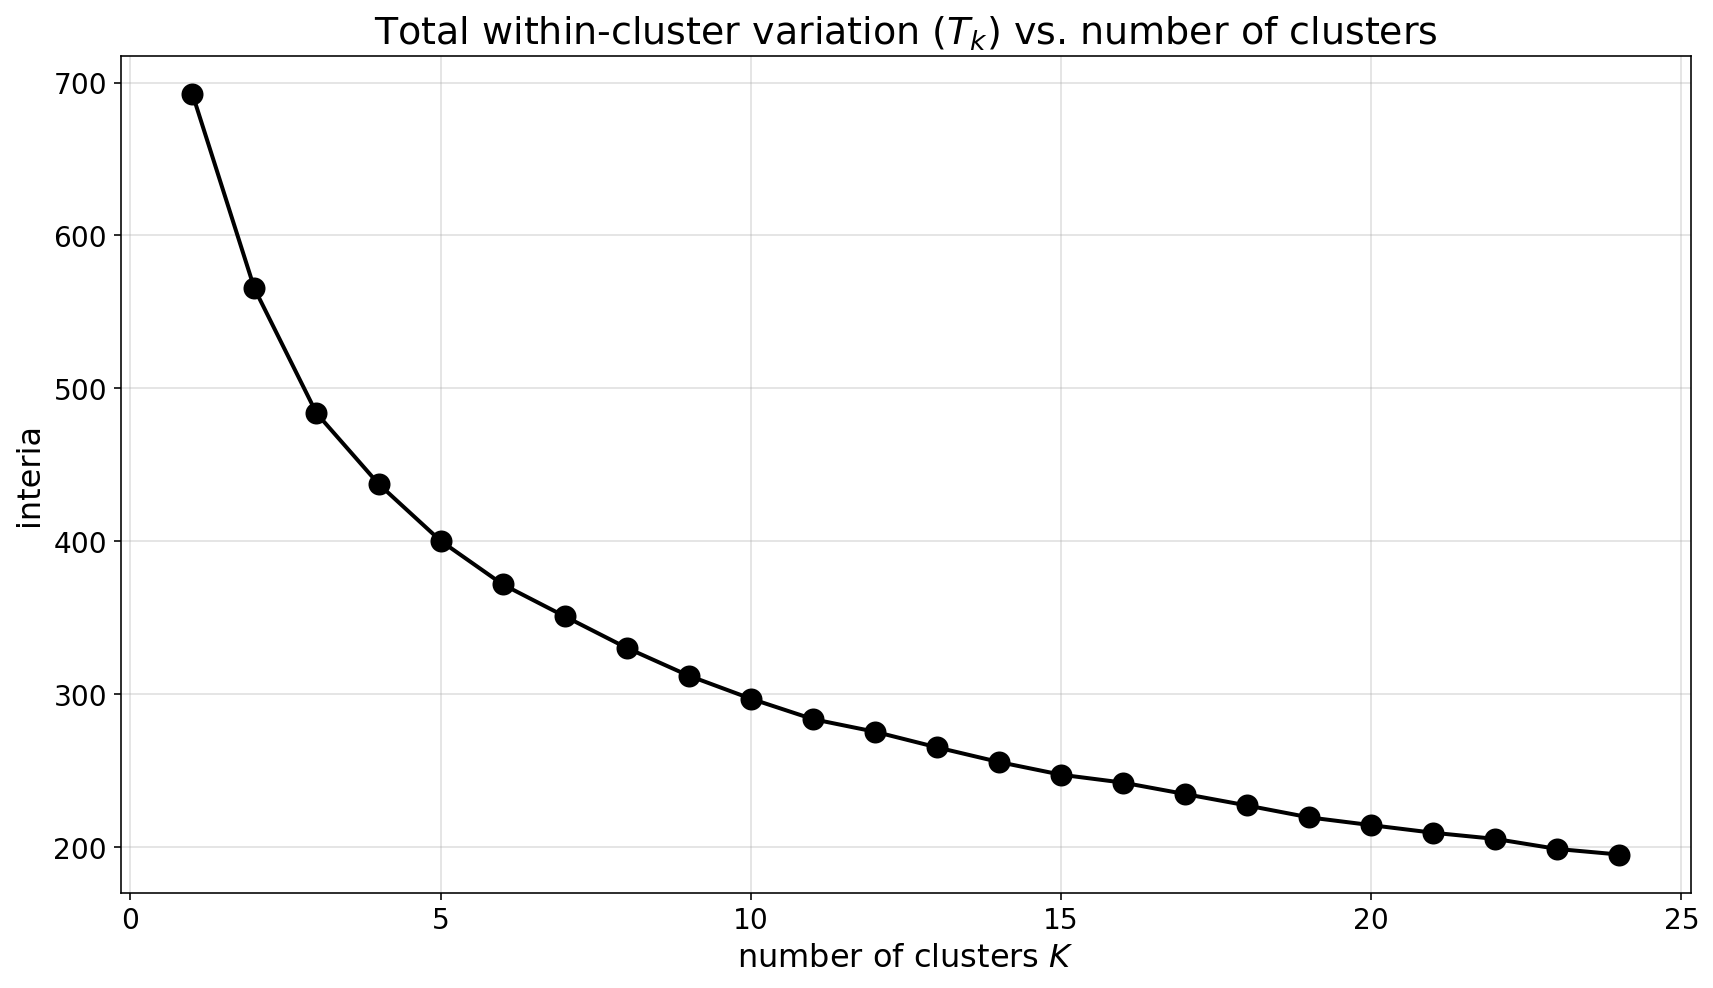

In [18]:
# set my plot parameters and generate my elbow plot
y_vals = tot_var_vals
x_vals = k_list
title = 'Total within-cluster variation ($T_k$) vs. number of clusters'
x_label = 'number of clusters $K$'
y_label = 'interia'

plot_line(x_vals, y_vals, title, x_label, y_label)

In [19]:
# save average silhouette score for each kmeans fit
# handle k=1 silhouette score error by inputting 0 as start to list
silscore_vals = [0] + [
    silhouette_score(X_data, kmeans_dict[k].labels_)
    for k in k_list[1:]
]

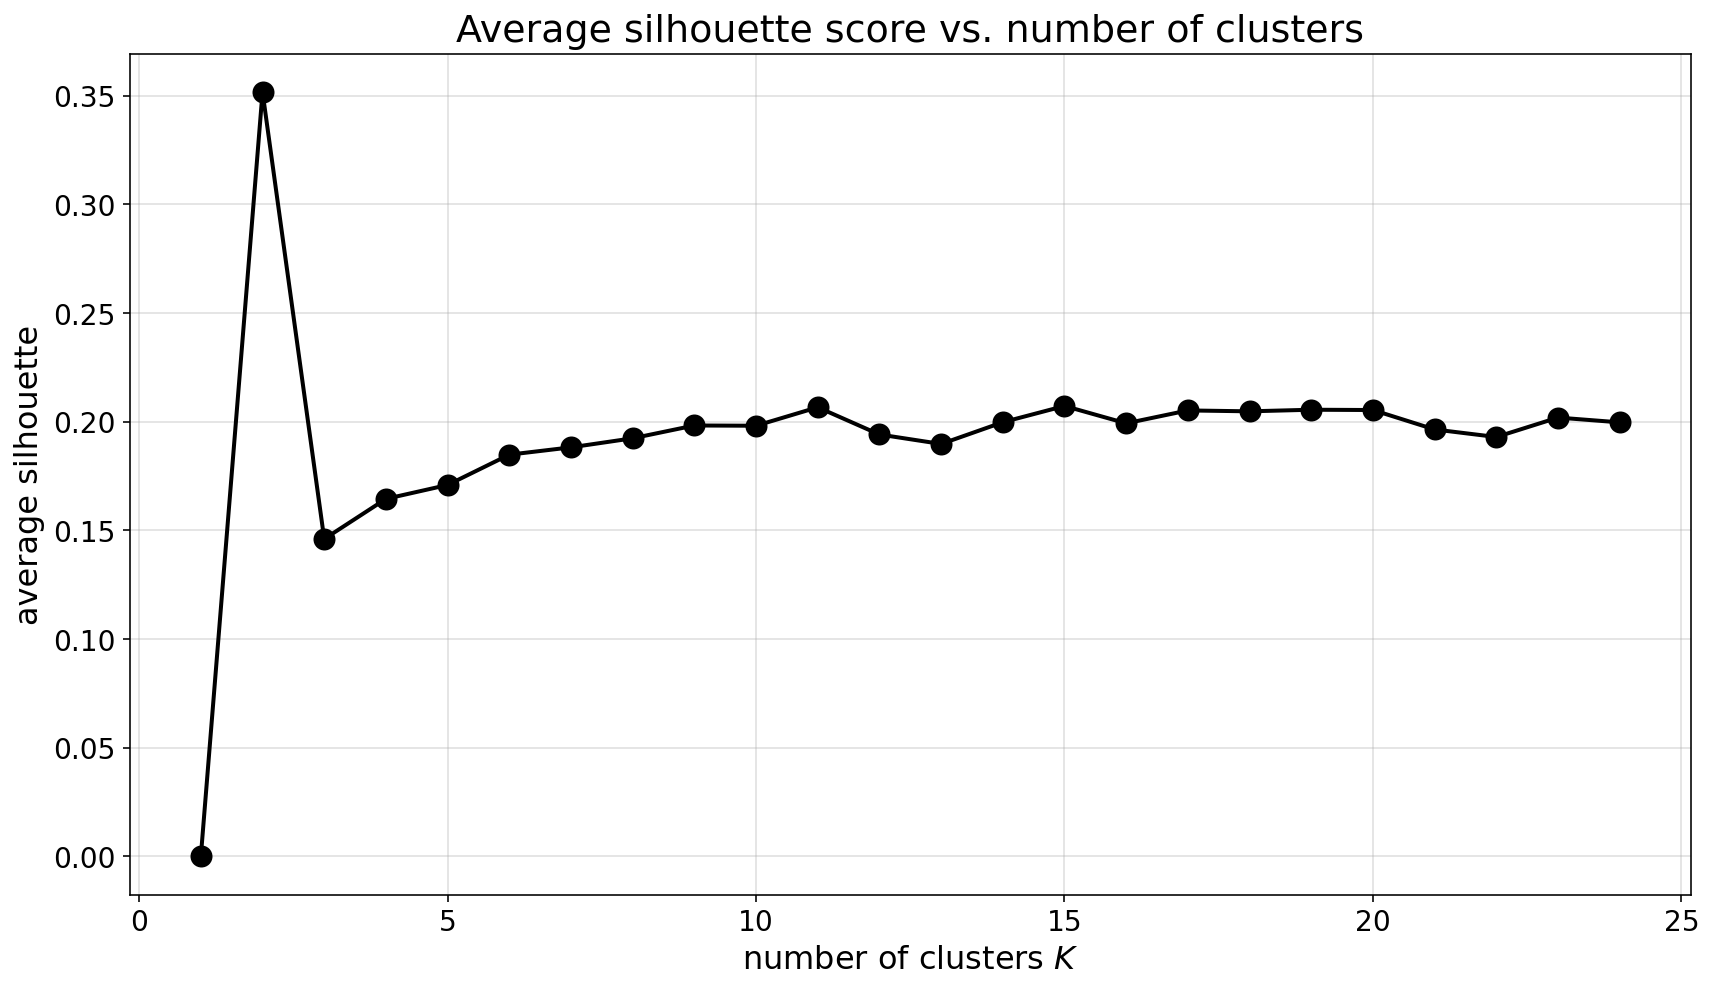

In [20]:
# set my plot parameters and generate my avg. silhouette score plot
y_vals = silscore_vals
x_vals = k_list
title = 'Average silhouette score vs. number of clusters'
x_label = 'number of clusters $K$'
y_label = 'average silhouette'

plot_line(x_vals, y_vals, title, x_label, y_label)

In [21]:
%%time
# Initialize OptimalK object
gs_obj = OptimalK()

# Provide OptimalK object with dataset and cluster array
n_clusters = gs_obj(X_data.values, n_refs=200, cluster_array=k_list)

print('Optimal clusters given estimated gap value: {}\n'.format(n_clusters))

Optimal clusters given estimated gap value: 21

CPU times: user 134 ms, sys: 63.9 ms, total: 197 ms
Wall time: 2.75 s


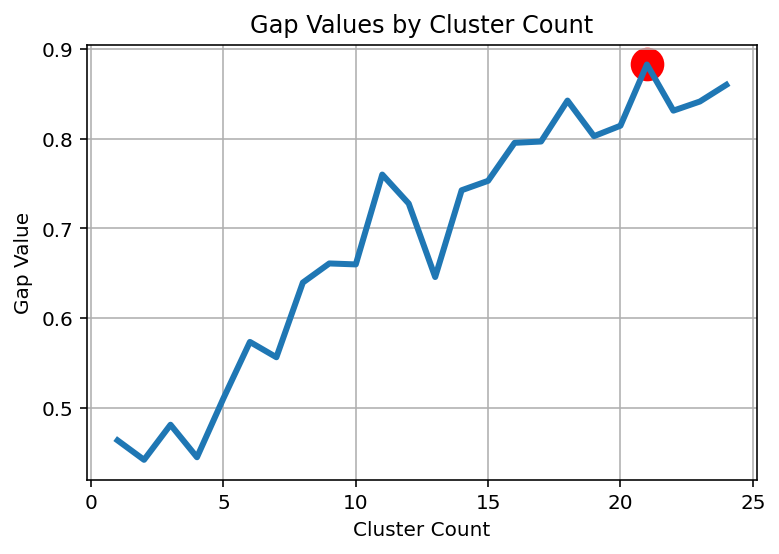

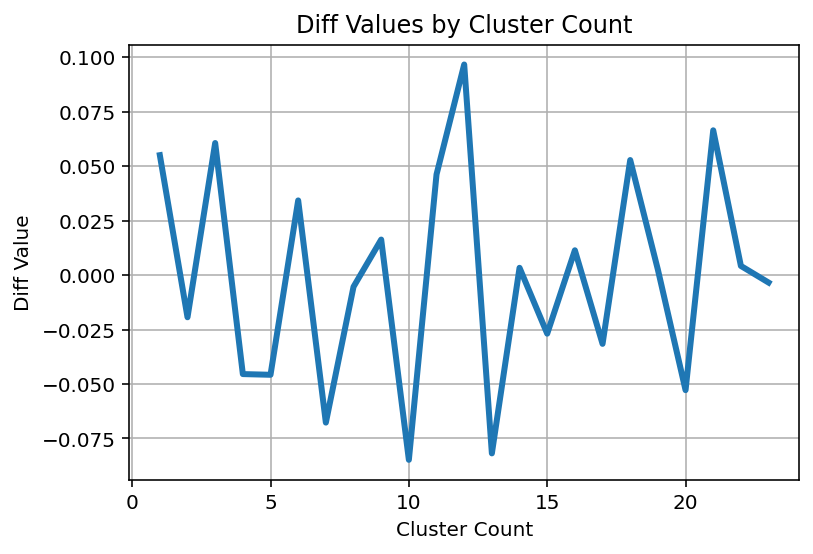

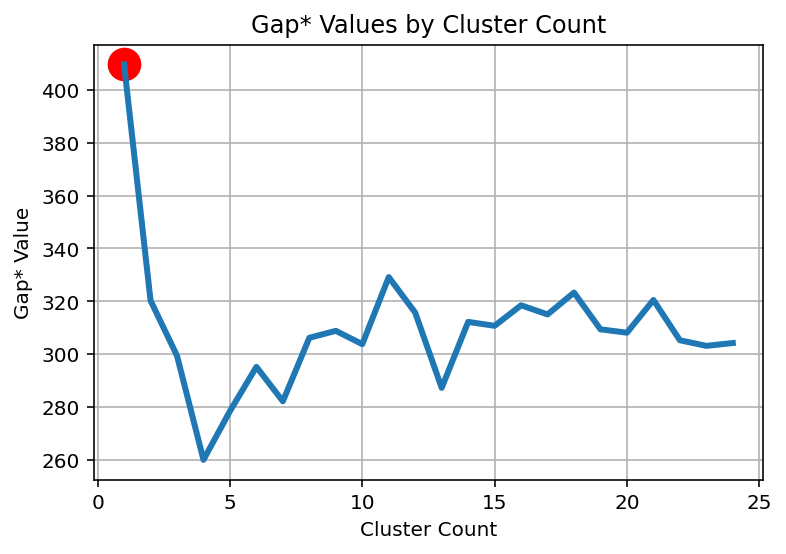

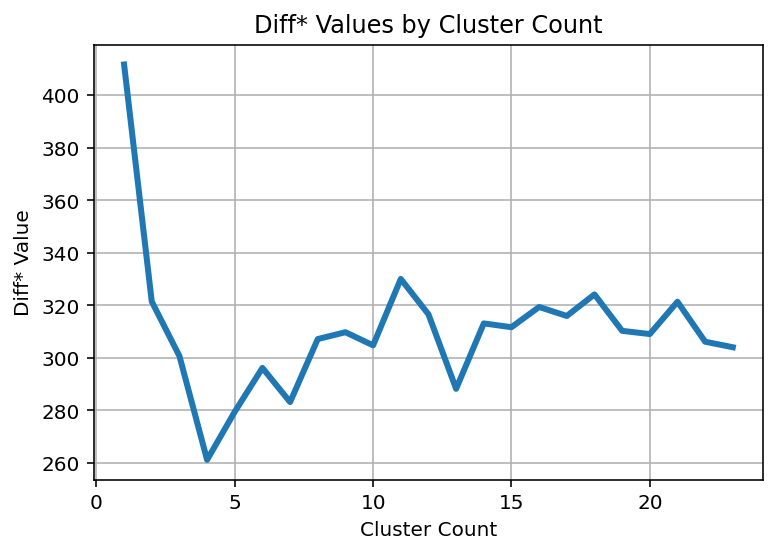

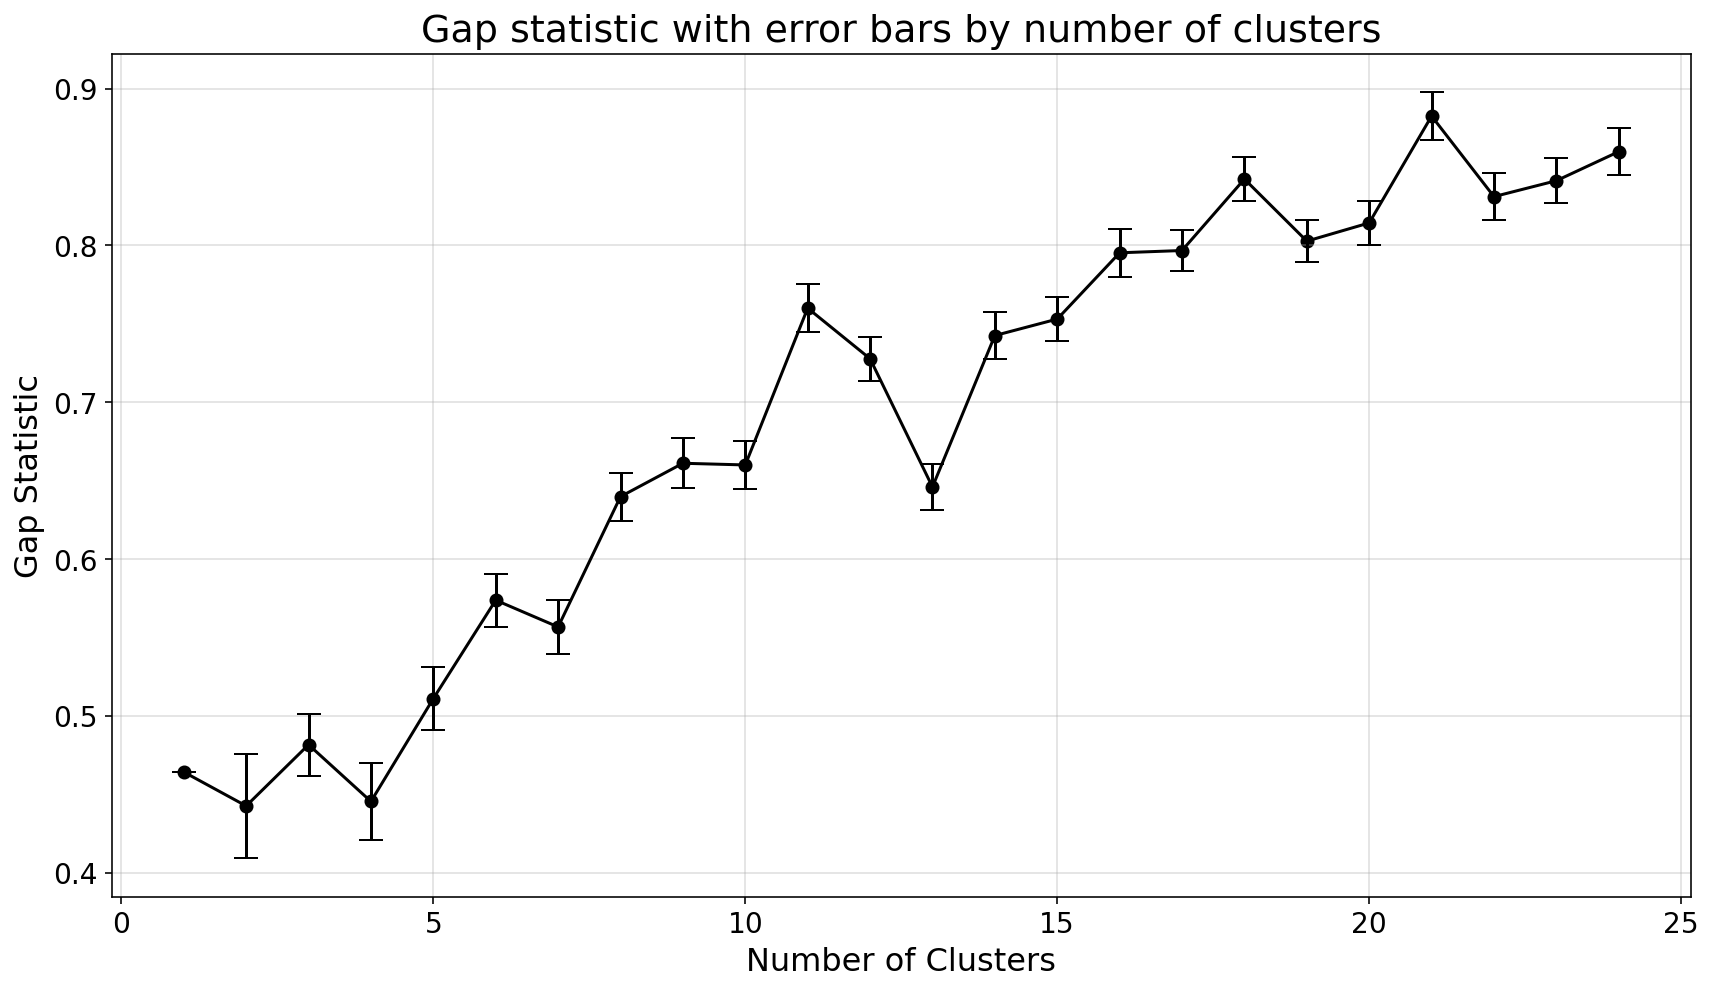

In [22]:
# Plot Gap statistic results for interpretation
gs_obj.plot_results()

# Plot Gap statistic with error bars
display_gapstat_with_errbars(gs_obj.gap_df)

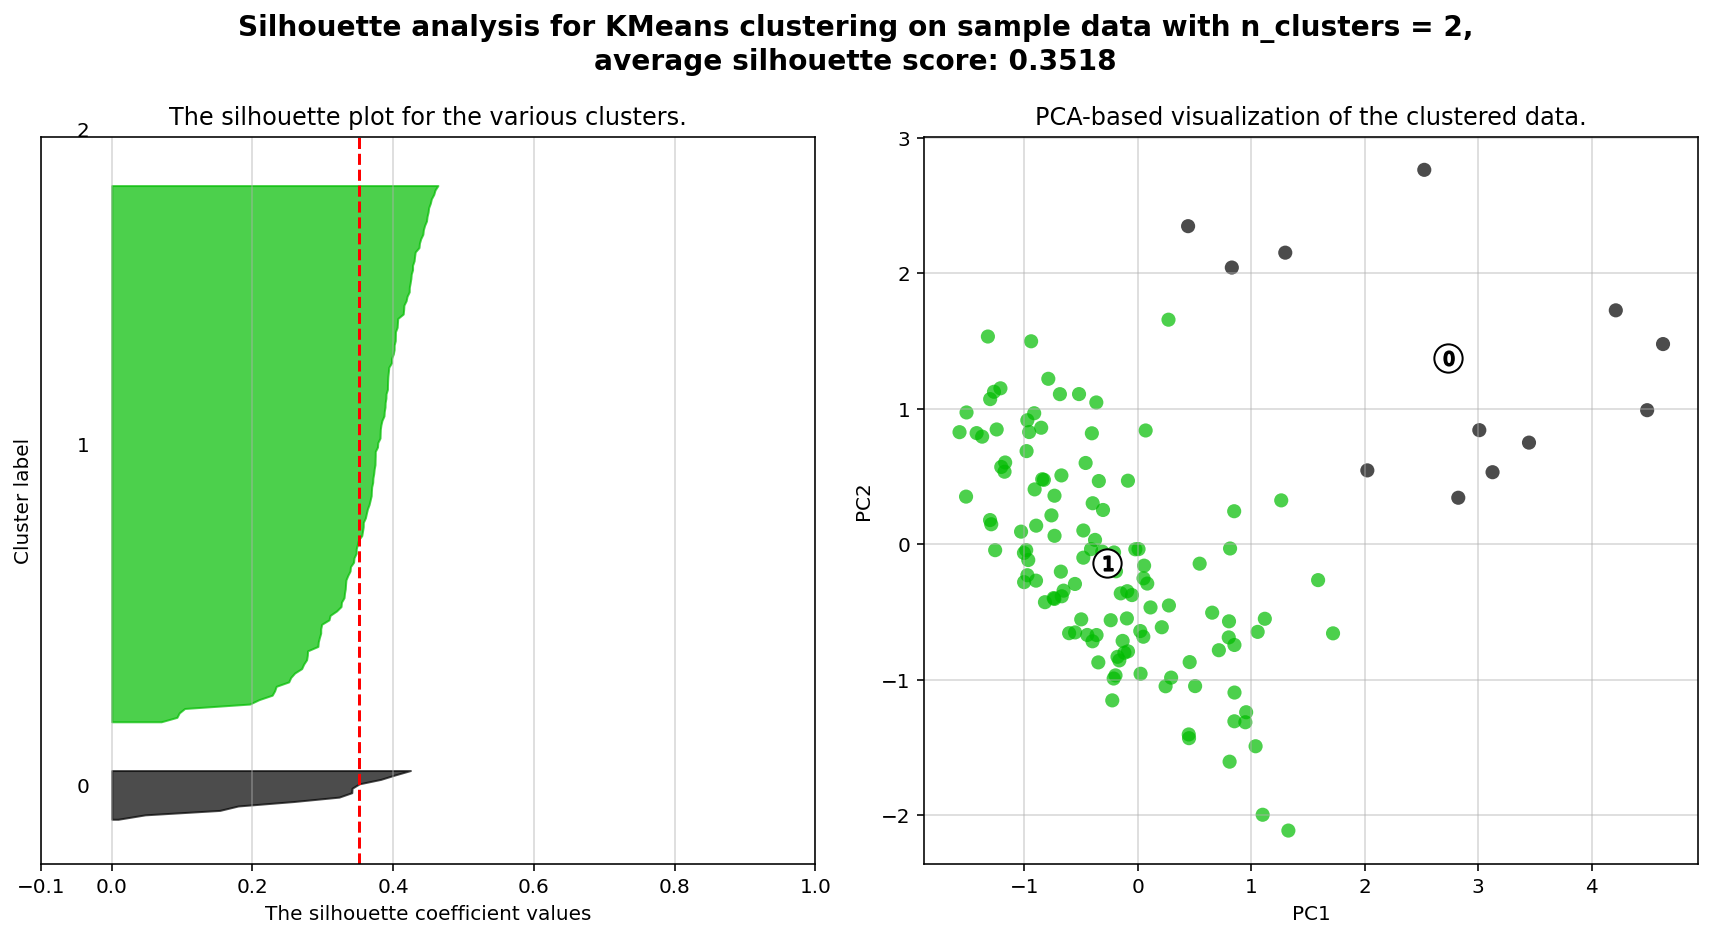

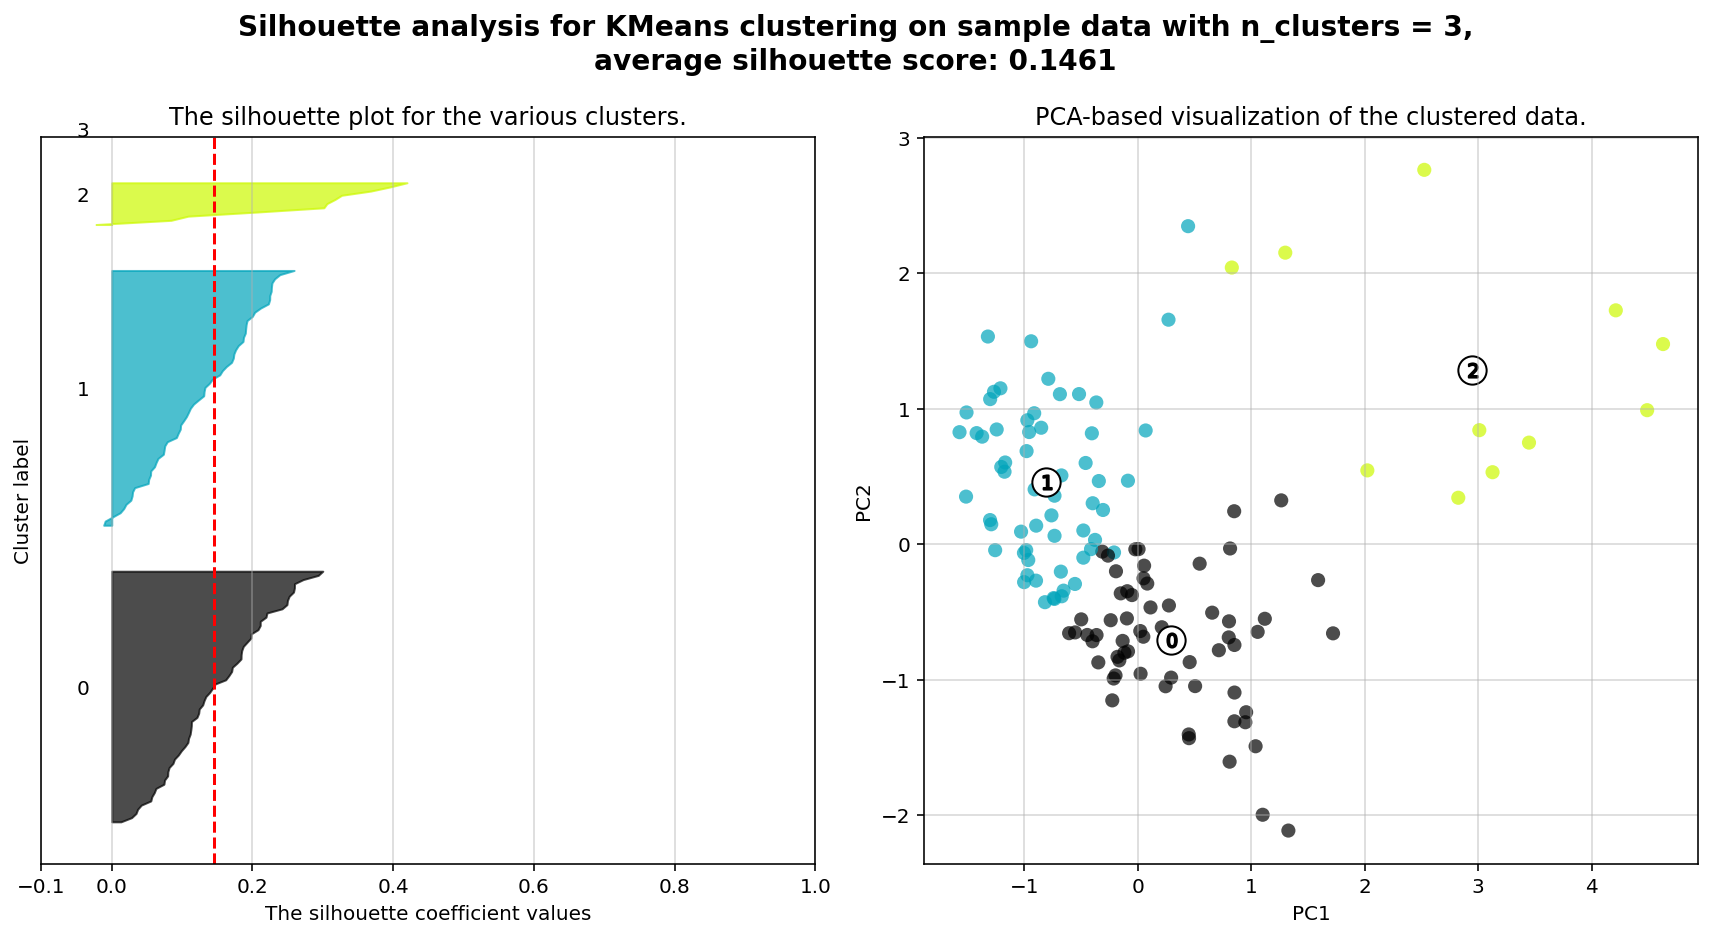

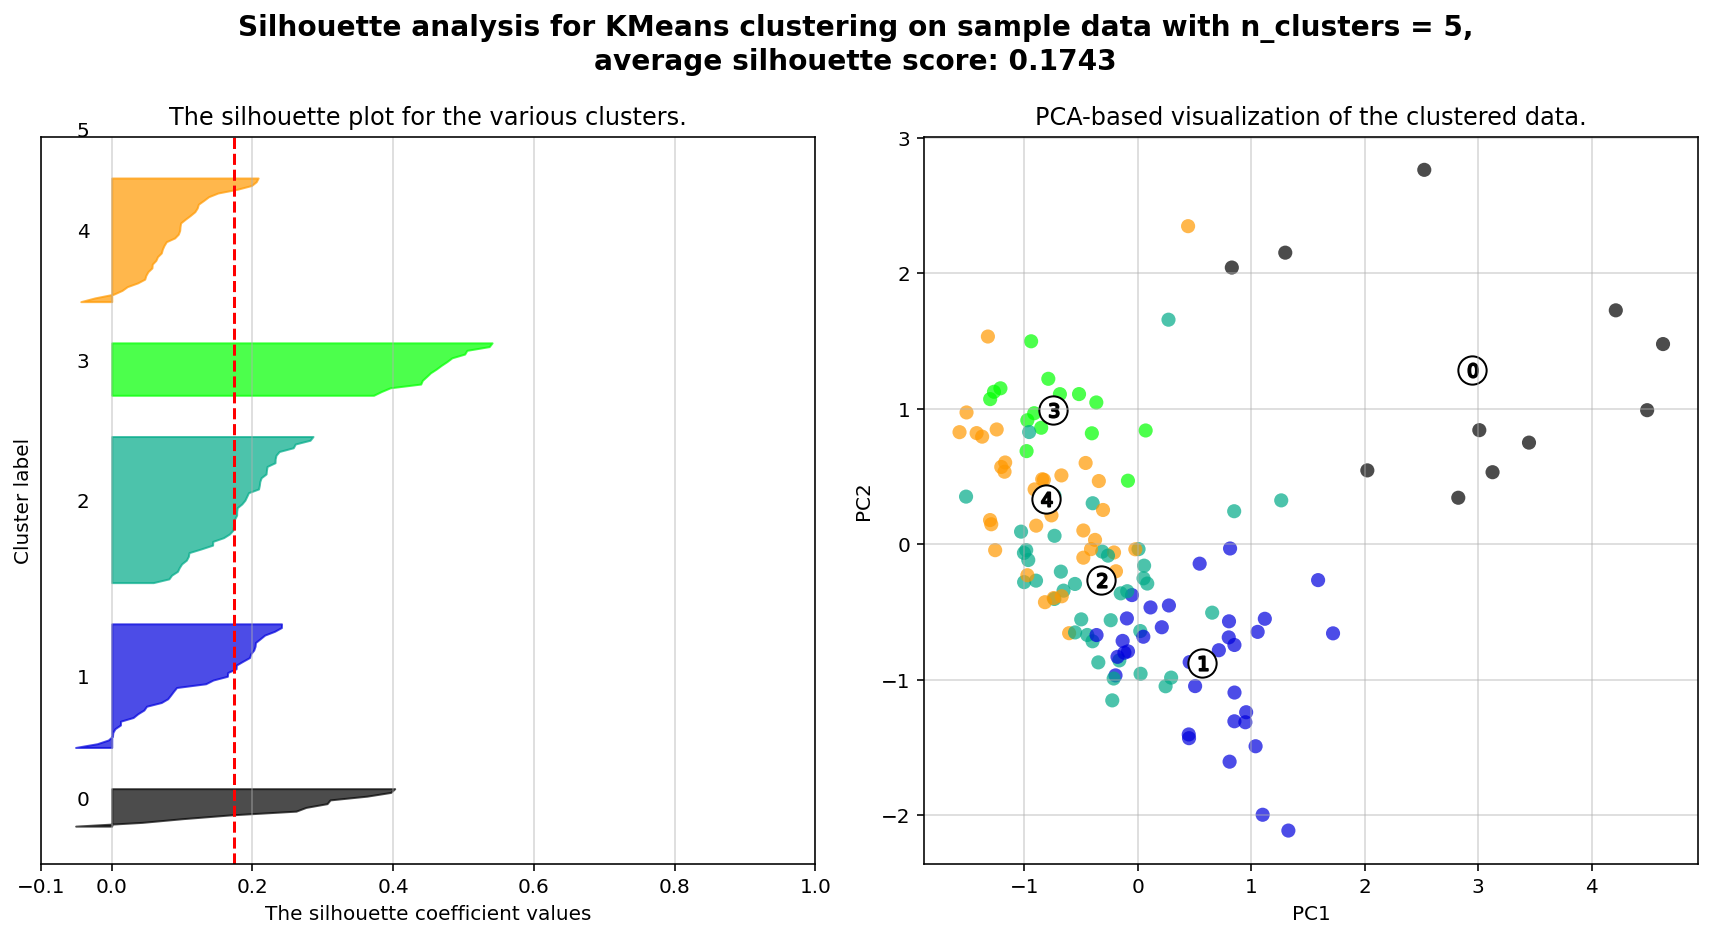

CPU times: user 7.33 s, sys: 160 ms, total: 7.49 s
Wall time: 2.15 s


In [23]:
%%time

# try with 2 clusters
n_classes = 2
n_init = 100

# fit kmeans algorithm and save to Cluster5 column in df
km_cluster2 = KMeans(
    n_clusters=n_classes, n_init=n_init, random_state=random_state
).fit(X_data)

cluster_labels = km_cluster2.labels_

silhouette_avg = silhouette_score(X_data, cluster_labels)

centers = silplot(X_data, cluster_labels, km_cluster2)


# try with 3 clusters
n_classes = 3
n_init = 100

# fit kmeans algorithm and save to Cluster5 column in df
km_cluster3 = KMeans(
    n_clusters=n_classes, n_init=n_init, random_state=random_state
).fit(X_data)

cluster_labels = km_cluster3.labels_

silhouette_avg = silhouette_score(X_data, cluster_labels)

centers = silplot(X_data, cluster_labels, km_cluster3)


# try with 5 clusters
n_classes = 5

# fit kmeans algorithm and save to Cluster5 column in df
km_cluster5 = KMeans(
    n_clusters=n_classes, n_init=n_init, random_state=random_state
).fit(X_data)

cluster_labels = km_cluster5.labels_

silhouette_avg = silhouette_score(X_data, cluster_labels)

centers = silplot(X_data, cluster_labels, km_cluster5)

# Check results against DBSCAN

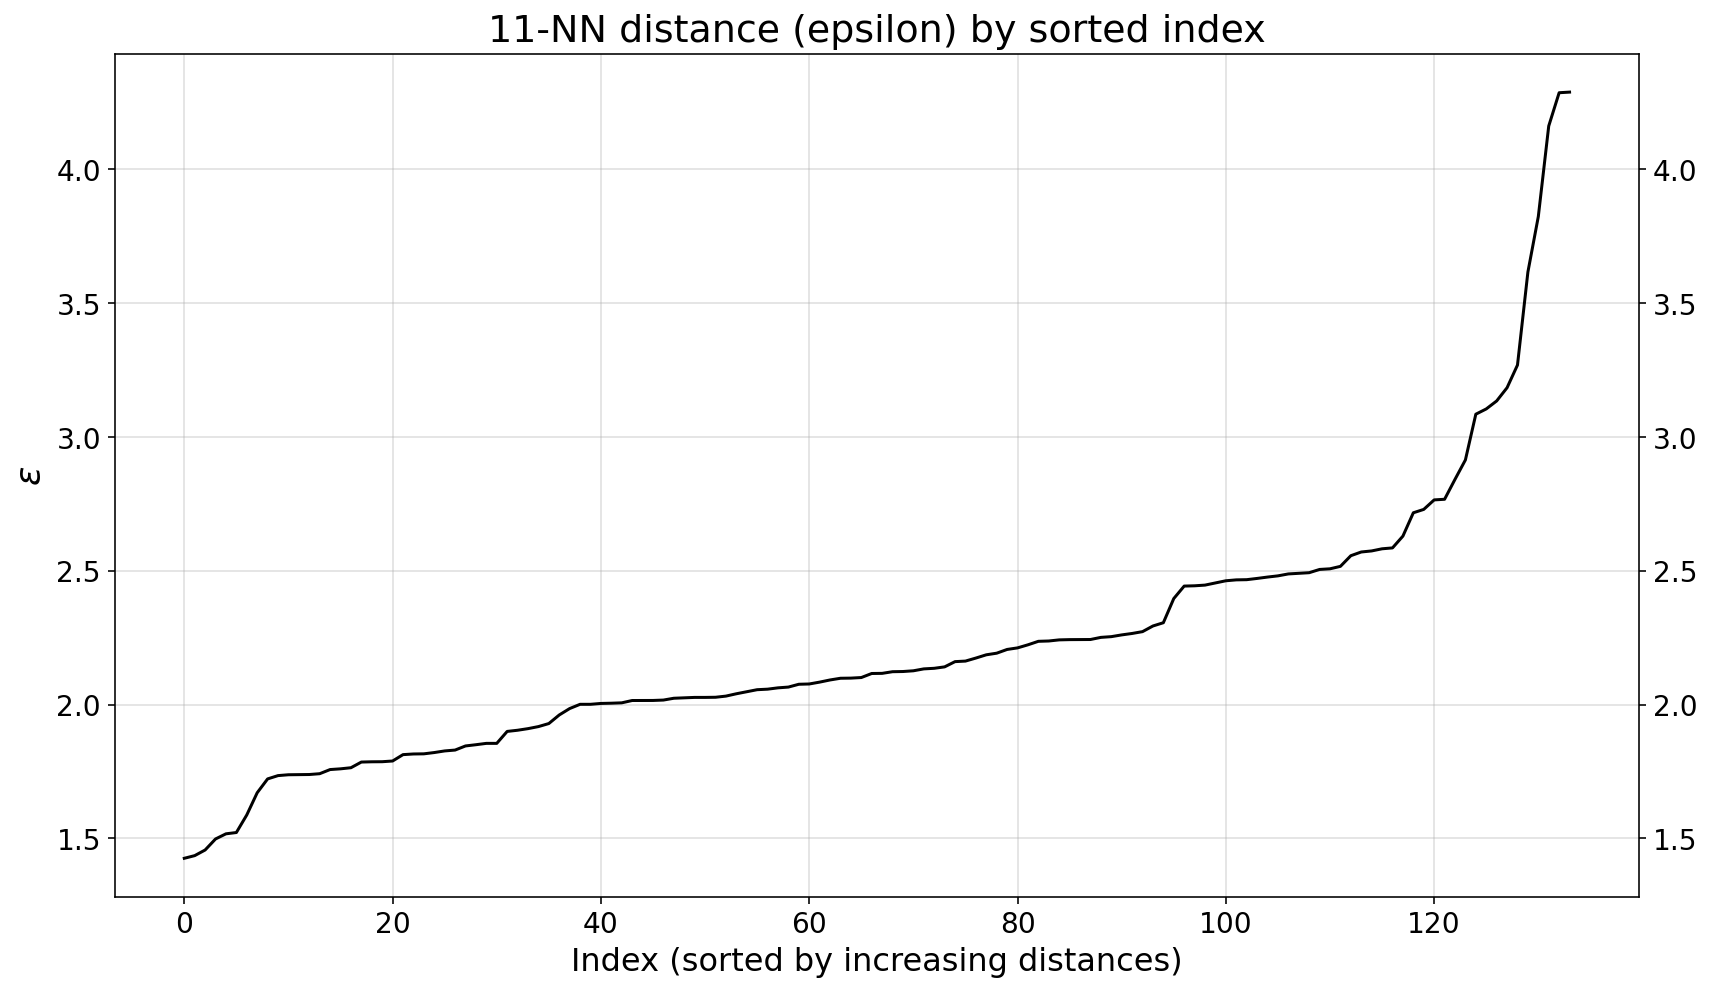

CPU times: user 1.61 s, sys: 23.7 ms, total: 1.63 s
Wall time: 267 ms


In [45]:
%%time
# Use general rule of thumb presented in class where min_samples
# is set to the number of features (12) x 2
min_samples = 12 # 54 * 2

# Use knn to plot and identify suitable epsilon values for DBSCAN
distances = fit_neighbors(X_data, min_samples)
plot_epsilon(distances, min_samples)


For the DBSCAN model:

DBSCAN(algorithm='auto', eps=2.25, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=12, n_jobs=None, p=None)

2 clusters were identified, and 25 of the n=134 observations were not assigned to any clusters.

The distribution of resulting labels are illustrated by this chart with un-clustered observations represented by the cluster labeled -1.


The resulting silhouette score, excluding the points not assigned to any cluster is:

	0.1843

CPU times: user 124 ms, sys: 7.31 ms, total: 132 ms
Wall time: 24.1 ms


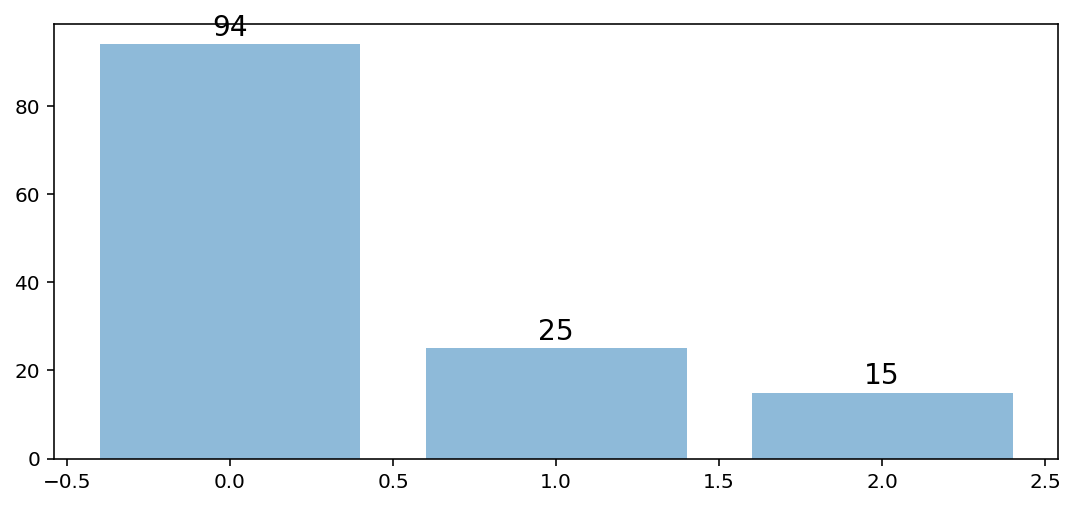

In [49]:
%%time

eps = 2.25

dbscan = fit_dbscan(X_data, min_samples, eps)

print_dbscan_results(dbscan)

# Check results against a Ward Method Dendrogram

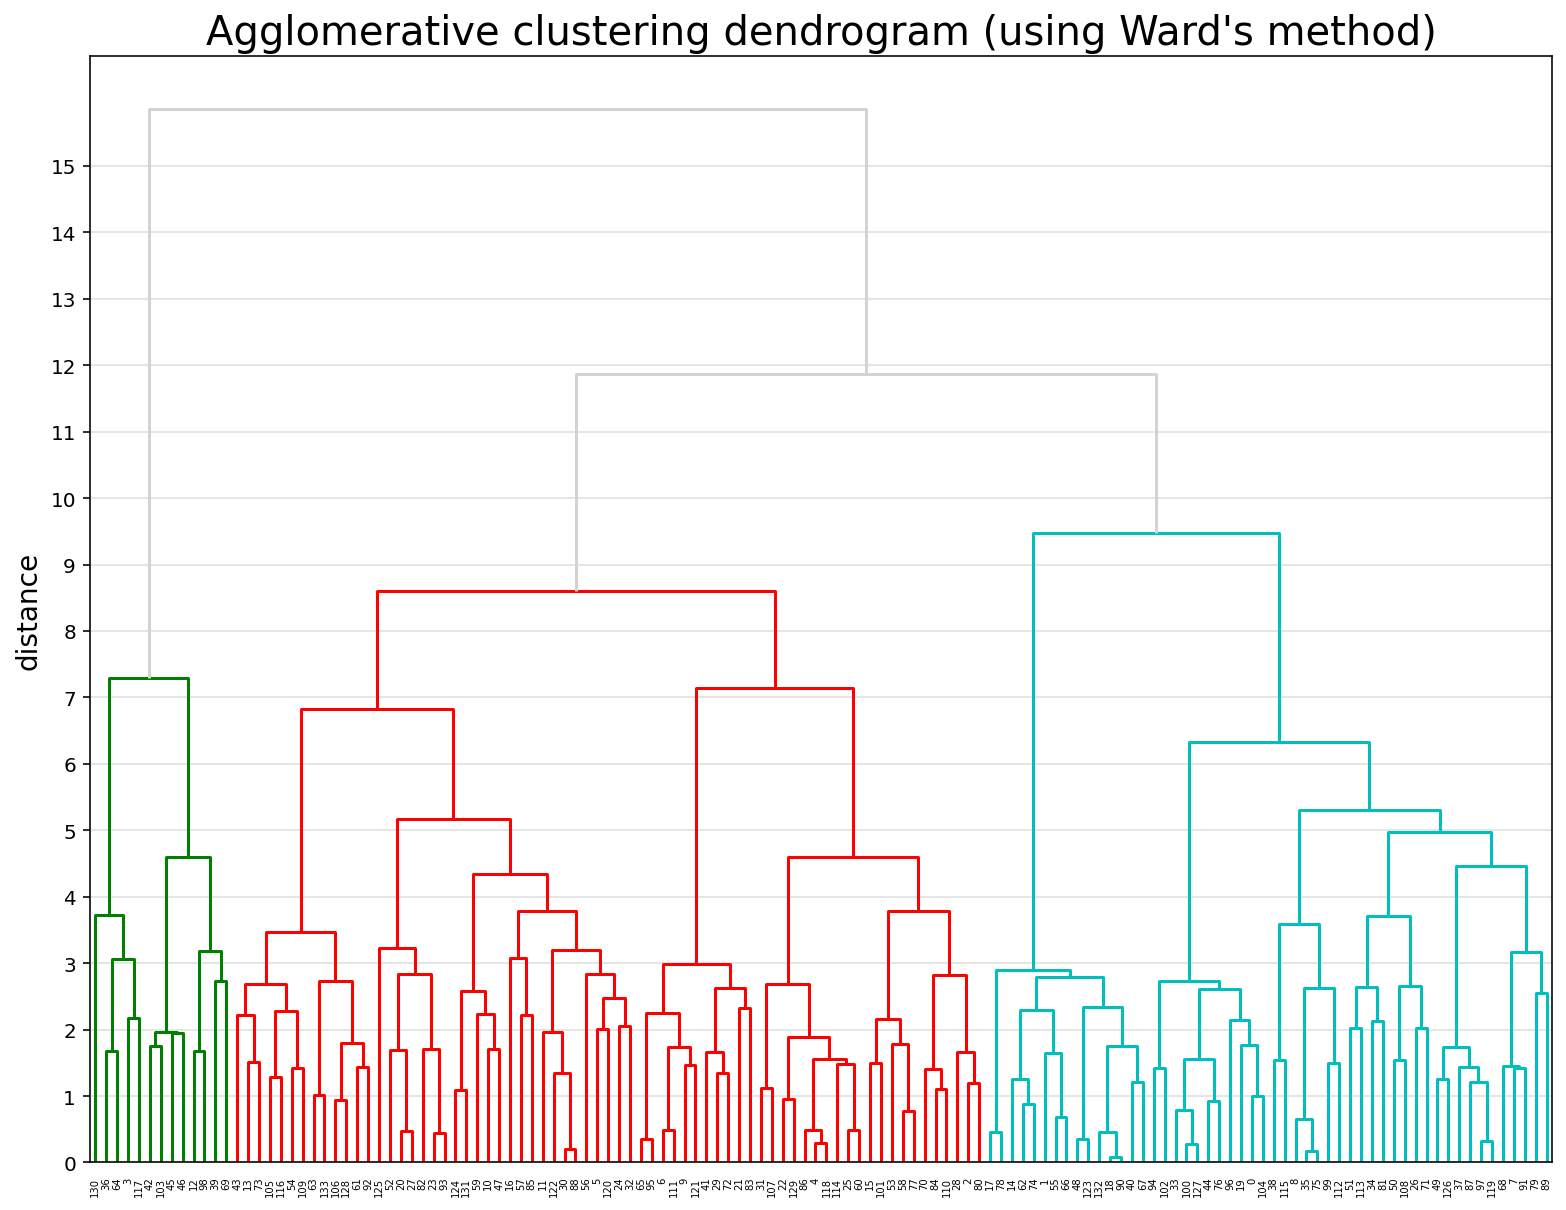

CPU times: user 5.25 s, sys: 199 ms, total: 5.45 s
Wall time: 2.69 s


In [26]:
%%time

# generate distance matrix
dist_mat = pdist(X_data, metric="euclidean")

# perform wards linkage on distance matrix
ward_data = hac.ward(dist_mat)

# generate dendrogram and plot it
plt.figure(figsize=(11, 8.5))

hac.dendrogram(ward_data, above_threshold_color='lightgray', orientation="top");

plt.title("Agglomerative clustering dendrogram (using Ward's method)", fontsize=20)
plt.grid(":", axis='y', alpha=0.4)
plt.yticks(np.arange(0, 16, 1), fontsize=10)
plt.ylabel('distance', fontsize=14)
plt.tight_layout()
plt.show()

In [27]:
# generate list of distance thresholds (t) to evaluate
t_list = np.arange(1, 16, 1)

# generate disctionary of cluster lables for each value t
label_dict = {
    t: hac.fcluster(ward_data, t=t, criterion='distance')
    for t in t_list
}

# calculate silhouette scores for each set of labels
sil_scores = [
    silhouette_score(X_data, labellings)
    for labellings in label_dict.values()
]

# generate list of cluster counts for each set of labels
cluster_counts =[
    len(set(labellings)) for labellings in label_dict.values()
]

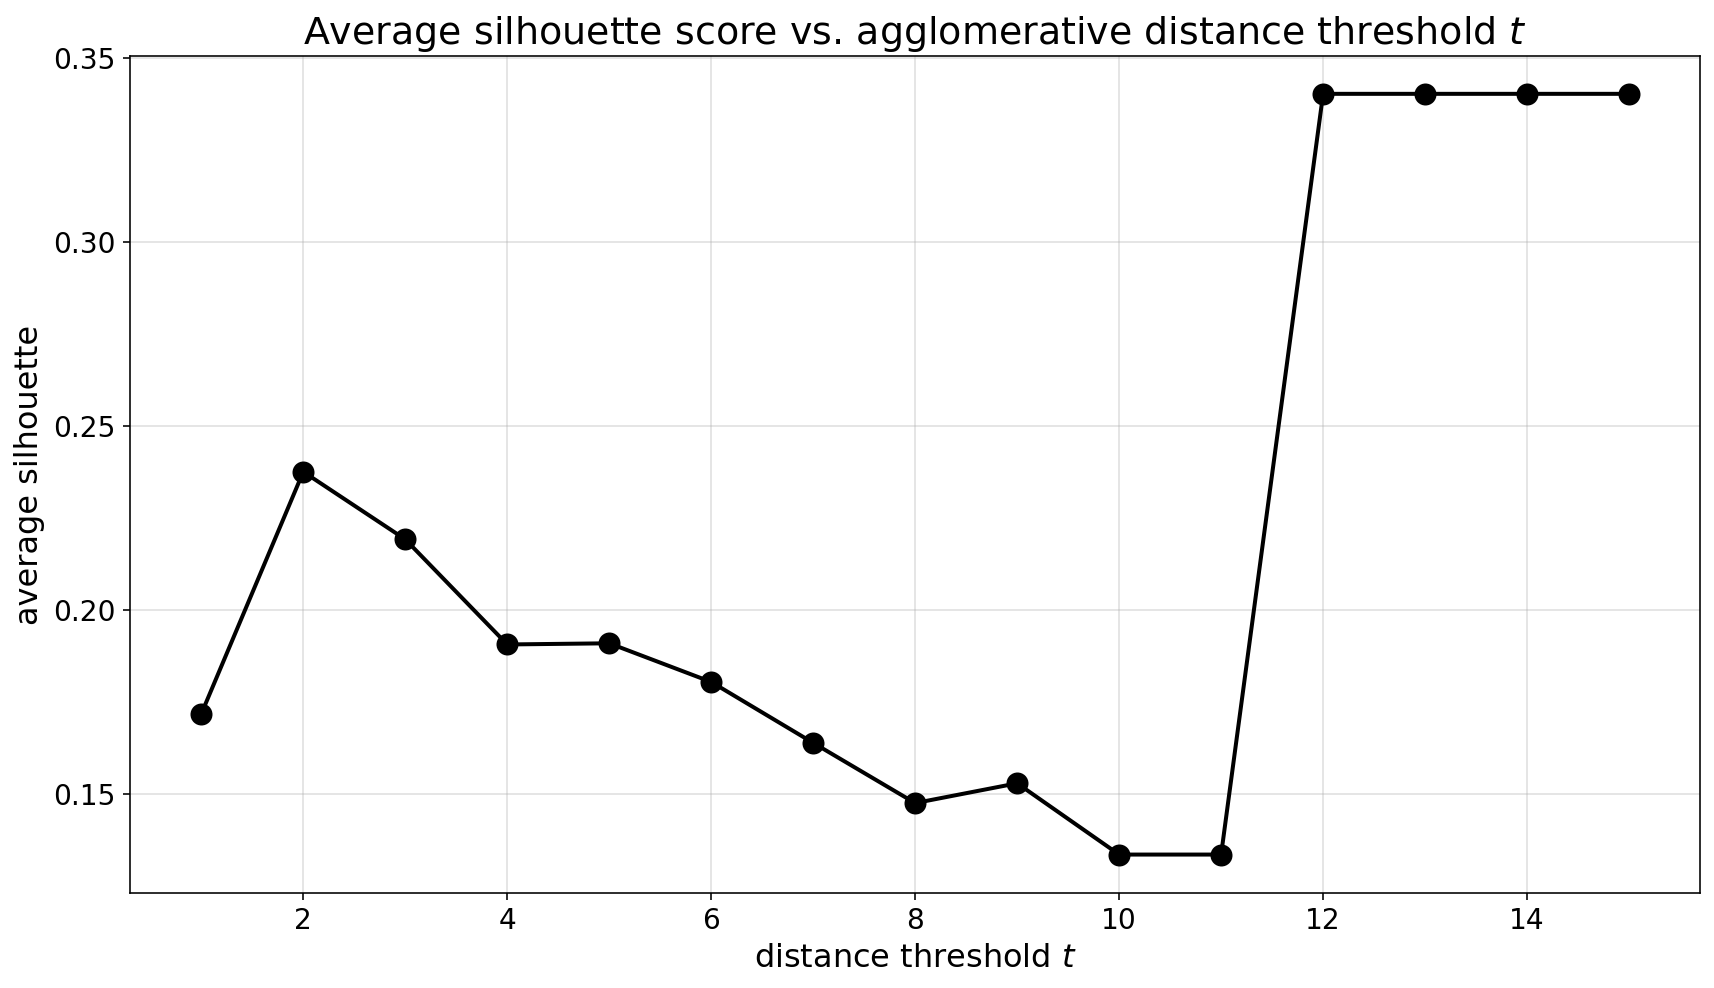

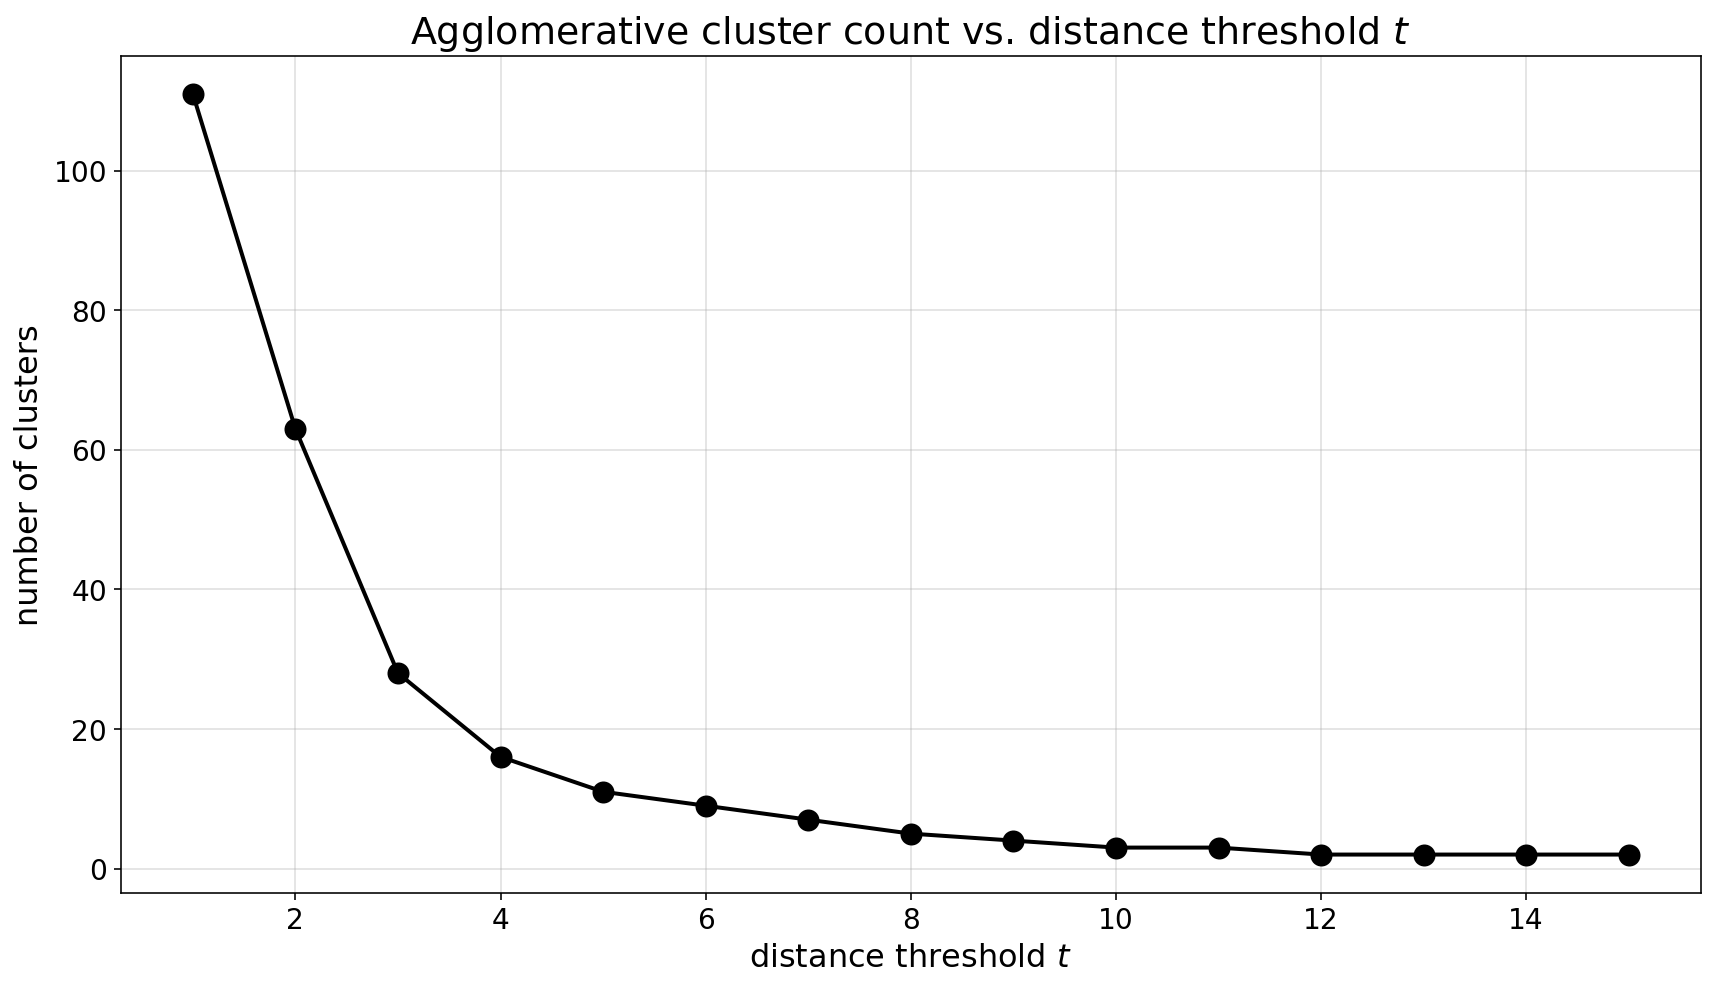


The maximum silhouette score of 0.340, suggests K=2 clusters at threshold t=12.



In [28]:
y_vals = sil_scores
x_vals = t_list
title = 'Average silhouette score vs. agglomerative distance threshold $t$'
x_label = 'distance threshold $t$'
y_label = 'average silhouette'

plot_line(x_vals, y_vals, title, x_label, y_label)

# y_vals = sil_scores
# x_vals = cluster_counts
# title = 'Average silhouette score vs. agglomerative cluster count'
# x_label = 'number of clusters'
# y_label = 'average silhouette'

# plot_line(x_vals, y_vals, title, x_label, y_label)

y_vals = cluster_counts
x_vals = t_list
title = 'Agglomerative cluster count vs. distance threshold $t$'
x_label = 'distance threshold $t$'
y_label = 'number of clusters'

plot_line(x_vals, y_vals, title, x_label, y_label)

max_sil = np.max(sil_scores)
max_idx = np.argmax(sil_scores)
max_sil_clust = cluster_counts[max_idx]
max_sil_thresh = t_list[max_idx]


print(
    '\nThe maximum silhouette score of {:.3f}, suggests K={} clusters at threshold t={:,}.\n'\
    ''.format(
        max_sil, max_sil_clust, max_sil_thresh,
    )
)

<a name='findings'></a>


# Findings:

<a href=#index>index</a>

- DBSCAN was difficult to get any clustering
- Dendrogram and Kmeans algrorithms appear to support a $k=3$ cluster grouping 

In [29]:
km3_test = km_cluster3.predict(X_test_std_sig)
km3_train = km_cluster3.predict(X_train_std_sig)

In [30]:
df_km3_train = pd.DataFrame(
    np.hstack(
        [
            X_train.index.values.reshape(-1,1),
            km3_train.reshape(-1,1)
        ]
    ),
    columns = ['PID', 'attribute_km3_label']
)


df_km3_test = pd.DataFrame(
    np.hstack(
        [
            X_test.index.values.reshape(-1,1),
            km3_test.reshape(-1,1)
        ]
    ),
    columns = ['PID', 'attribute_km3_label']
)

df_km3_train.shape, df_km3_test.shape

((134, 2), (15, 2))

In [31]:
df_km3_train.info()
df_km3_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   PID                  134 non-null    int64
 1   attribute_km3_label  134 non-null    int64
dtypes: int64(2)
memory usage: 2.2 KB


,PID,attribute_km3_label
0,204,0
1,577,1
2,664,0
3,402,2
4,760,0


# Save resulting Kmeans $k=3$ train and test values, and `sklearn` model object

In [32]:
# save finalized encodings dataframes to .csv
df_km3_train.to_csv(savedata_train, index=False)
df_km3_test.to_csv(savedata_test, index=False)

# save fitted sklearn Kmeans model using pickle
pickle.dump(km_cluster3, open(savemodel, 'wb'))